In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import matplotlib as mpl
%matplotlib inline  
%load_ext autoreload
%autoreload 2
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


# Question 1
## Part 1: A naive analysis

We load the data and compare the outcome for the two groups (treatment and control).

In [2]:
df_full = pd.read_csv('lalonde.csv')
df_full.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
def describe_treatment_control(df, col_name):
    print('Descriptive statistics for the matched cases in the treatment group\n')
    print(df[df.treat==1][col_name].describe())

    print('\n\nDescriptive statistics for the matched cases in the control group')
    print(df[df.treat==0][col_name].describe())

In [4]:
describe_treatment_control(df_full, 're78')

Descriptive statistics for the matched cases in the treatment group

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


Descriptive statistics for the matched cases in the control group
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


In [5]:
print('Descriptive statistics for all real earnings in 1974:')
print(df_full.re74.describe())
print('\n\nDescriptive statistics for all real earnings in 1975:')
print(df_full.re75.describe())

Descriptive statistics for all real earnings in 1974:
count      614.000000
mean      4557.546569
std       6477.964479
min          0.000000
25%          0.000000
50%       1042.330000
75%       7888.498250
max      35040.070000
Name: re74, dtype: float64


Descriptive statistics for all real earnings in 1975:
count      614.000000
mean      2184.938207
std       3295.679043
min          0.000000
25%          0.000000
50%        601.548400
75%       3248.987500
max      25142.240000
Name: re75, dtype: float64


Now we will plot the histograms of the outcome variable for the two groups (participants and non-participants) side by side (0 is untreated and 1 is treated):

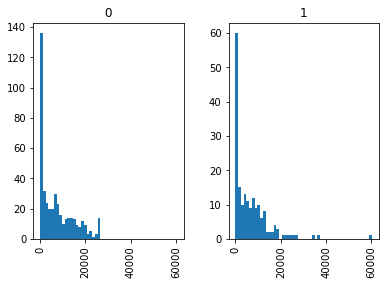

In [6]:
ax1, ax2 = df_full.hist(column='re78', by = 'treat', range=[0, df_full.re78.max()], bins = 50)


To the naive researcher [*tries hard to sound naive*] it seems that those who have not received the training actually have higher incomes because the mean is higher for the non-participants (i.e. control group), and also, although the 25% quartile is higher for the participants (i.e. treatment group), the 50% and 75% quartiles are considerably higher for the non-participants. Also, although the non-participants seem to have a much lower maximum, the number of participants who actually attain values higher than the maximum for the non-participants is only 5, which is a very small number of people. So basically, according to the naive researcher we're roleplaying as, the training program *backfired* and actually left the participants worse off than they would have been without the training.

## Part 2: Let's start acting like the ADA students we are

We will now compare the distributions of all variables across the treatment and control groups.

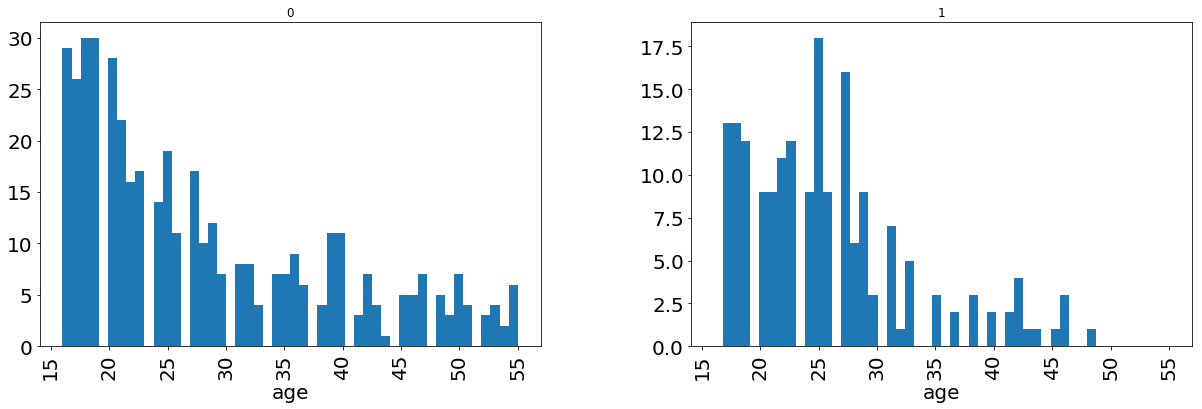

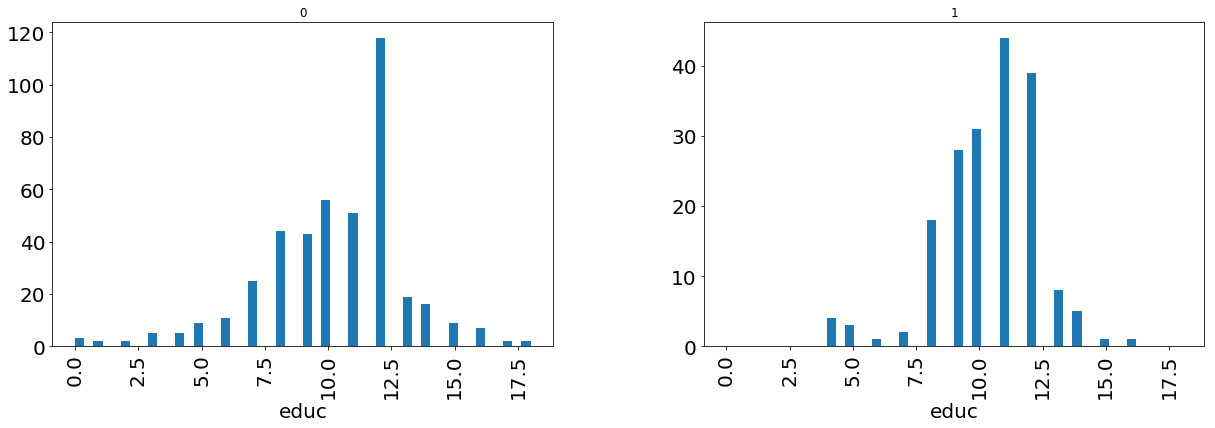

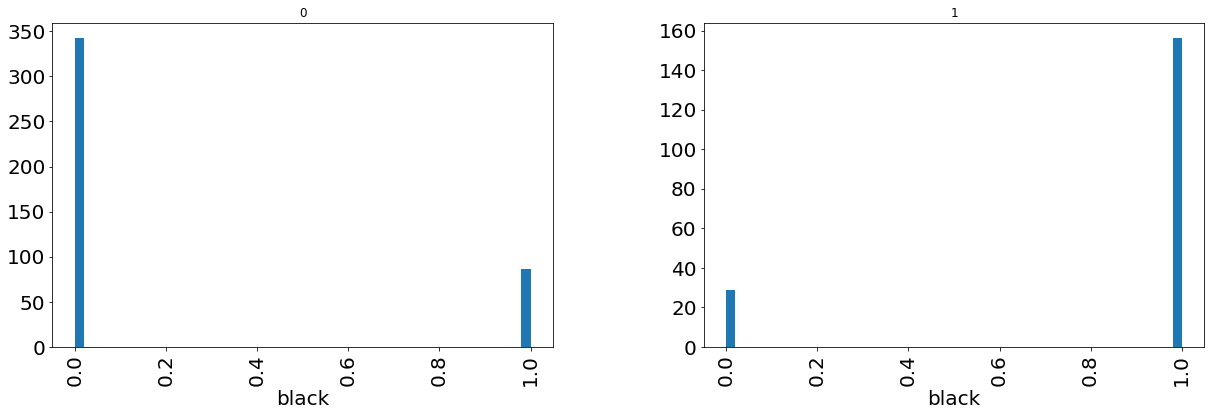

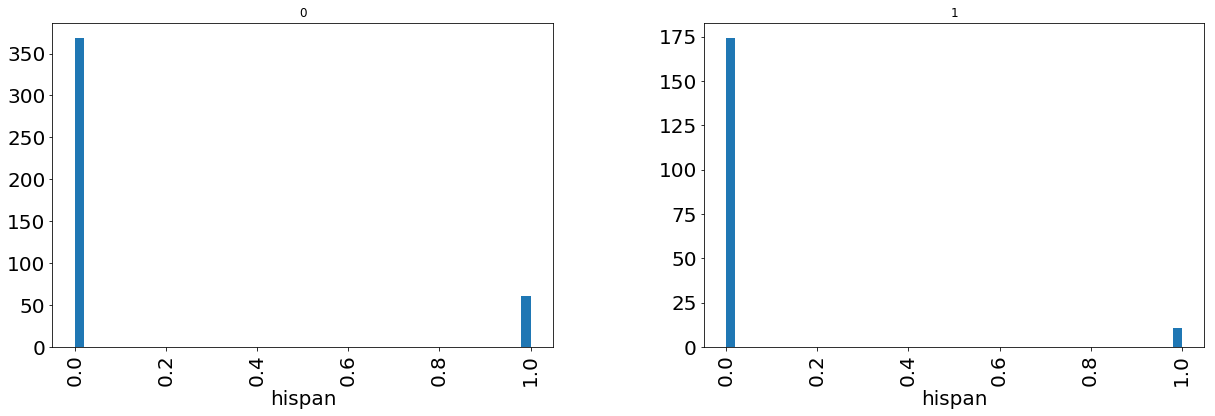

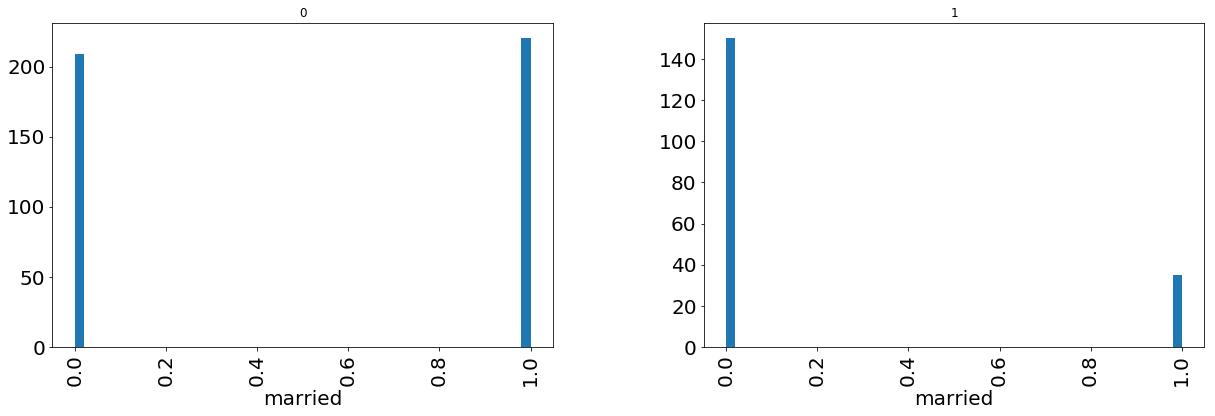

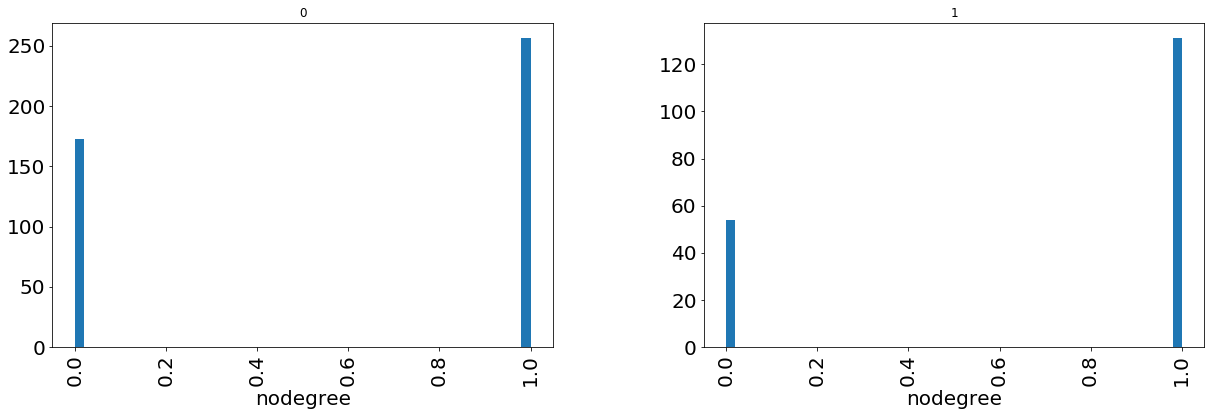

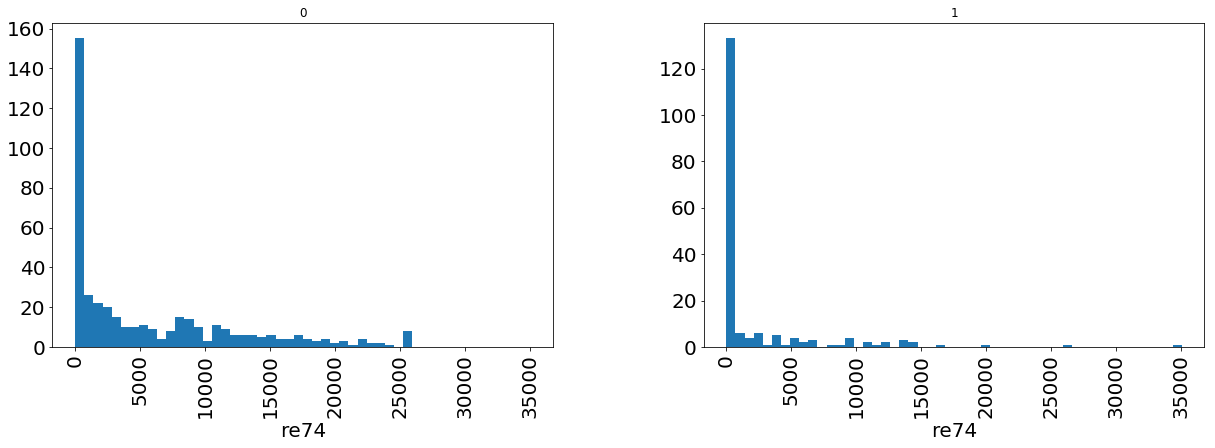

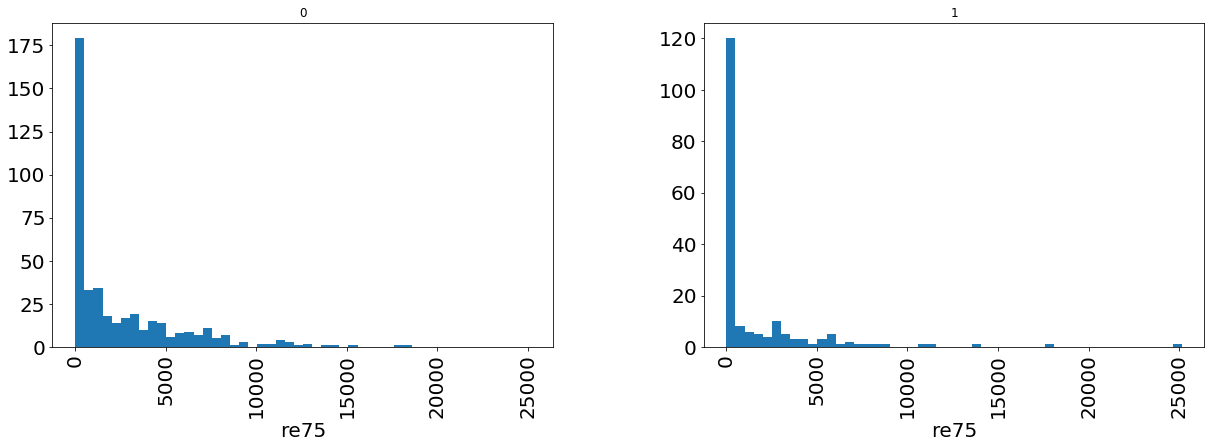

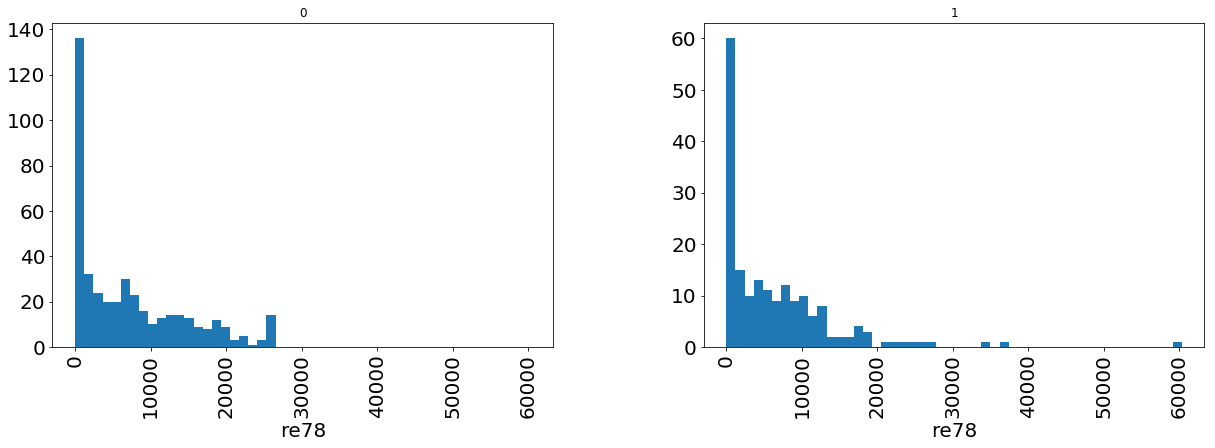

In [7]:
#plt.subplot(7,2,1)
#fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True)
def create_subplot(df, column_name):
    ax1, ax2 = df.hist(column=column_name, by='treat', range=[df[column_name].min(), df[column_name].max()], bins=50, figsize=(20,6), xlabelsize=20, ylabelsize=20)
    ax1.set_xlabel(column_name, size=20)
    ax2.set_xlabel(column_name, size=20)

def do_variable_histograms(df):
    for column_name in df.columns:
        if (column_name == 'id' or column_name == 'treat'):
            continue
        create_subplot(df, column_name)

do_variable_histograms(df_full)


The two groups seem unbalanced in three variables: black (0 for non-black, 1 for black), married (1 for married, 0 for not), and education. They are especially unbalanced in the black variable, where most of the control group are non-black and the majority of the treatment group are black. This means that existing differences in pay between different racial groups could be affecting our conclusions (not our conclusions though - the conclusions of the naive researcher in part 1). Let us see descriptive statistics for these 3 variables across the two groups in greater detail.

The first variable, black, is a Bernoulli random variable, so the mean is going to be meaningful (sorry for the pun). You can see the great difference between the two groups:

In [8]:
df_treat_1 = df_full[df_full.treat == 1]
df_treat_0 = df_full[df_full.treat == 0]
print('Treatment mean\n')
print(df_treat_1.black.mean())
print('\n\nControl mean\n')
print(df_treat_0.black.mean())

Treatment mean

0.8432432432432433


Control mean

0.20279720279720279


The second, married, is also a Bernoulli variable:

In [9]:
print('Treatment mean\n')
print(df_treat_1.married.mean())
print('\n\nControl mean\n')
print(df_treat_0.married.mean())

Treatment mean

0.1891891891891892


Control mean

0.5128205128205128


The third, education, looks relatively close to a Gaussian, albeit skewed (but bear in mind that it's discrete!).

In [10]:
print('Treatment\n')
print(df_treat_1.educ.describe())
print('\n\nControl\n')
print(df_treat_0.educ.describe())

Treatment

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64


Control

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64


## Part 3: Propensity score calculation

We set the inverse of the regularisation parameter (C) to a very high value because we don't really need regularisation here; we just want to estimate the P(Z=1|x) for our data (for which a model like logistic regression is perfect because it predicts just that), which means we don't need to be able to generalise (so overfitting is not an issue). 
Afterwards, we'll be able to match 

In [11]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression(C=1e6)
features_df = df_full[['age', 'educ', 'black', 'hispan', 'married', 'nodegree']]
X = features_df.values.astype(float)
Y = df_full.treat.values
all_ids = df_full.id.values
log_reg.fit(X, Y)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [12]:
#The following function gives us two values per each sample, which are P(Z=0|x) and P(Z=1|x) respectively.
a = log_reg.predict_proba(X)
propensity_scores = a[:, 1]
propensity_scores[0:5]

array([ 0.58674564,  0.21430586,  0.64042713,  0.76455739,  0.68732504])

In preparation for the next part, we separate ids and propensity scores for the treatment and control groups.

In [13]:
treatment_prop_scores = propensity_scores[Y == 1]
treatment_ids = all_ids[Y == 1]
control_prop_scores = propensity_scores[Y == 0]
control_ids = all_ids[Y == 0]

## Part 4: Matching on propensity scores

Now we create a bipartite graph, with the treatment group member ids forming one part and the control group member ids forming the other. The weight we assign to the edge between a control case ($x_1$) and a treatment case ($x_2$) is equal to $ - | e( x_1 ) - e( x_2 ) |$. Therefore, running a maximum-weight, maximum-cardinality matching on this graph will yield a matching that matches every member of the treatment group (because they're fewer than the control group), each with exactly one member of the control group while no control case is matched with more than one treatment case, all while maximising the sum of negated absolute values - which is equivalent to minimising the sum of absolute values.

In [14]:
import networkx as nx
g = nx.Graph()
g.add_nodes_from(treatment_ids, bipartite=1)
g.add_nodes_from(control_ids, bipartite=0)
edge_list = []
for t_index in range(len(treatment_ids)):
    for c_index in range(len(control_ids)):
        edge_list.append((treatment_ids[t_index], control_ids[c_index], -abs(treatment_prop_scores[t_index] - control_prop_scores[c_index])))

g.add_weighted_edges_from(edge_list)
matching_result = nx.max_weight_matching(g, maxcardinality=True)

In [15]:
len(list(matching_result))

370

In [16]:
matched_df_1 = df_full[df_full.id.isin(matching_result)]

Now we do what we did in part 1, but this time only for the matched members of the control and treatment groups:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB99B953C8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001DB9CB990F0>], dtype=object)

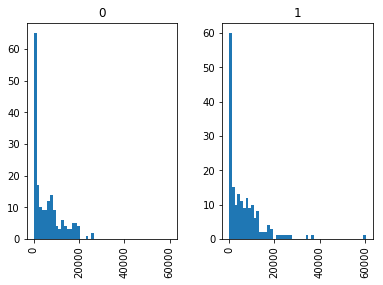

In [17]:
matched_df_1.hist(column='re78', by = 'treat', range=[0, matched_df_1.re78.max()], bins = 50)

In [18]:
describe_treatment_control(matched_df_1, 're78')

Descriptive statistics for the matched cases in the treatment group

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


Descriptive statistics for the matched cases in the control group
count      185.000000
mean      5744.634084
std       6317.498541
min          0.000000
25%         54.675880
50%       3683.972000
75%       8923.991000
max      25564.670000
Name: re78, dtype: float64


Even if we remove the seemingly outlier points, the quartiles still show an increase over the control group.

In [19]:
treat_matched = matched_df_1[matched_df_1.treat==1]
treat_matched = treat_matched[treat_matched.re78 < 30000]
treat_matched.re78.describe()

count      182.000000
mean      5733.721940
std       6093.361164
min          0.000000
25%        338.649875
50%       4164.272500
75%       9511.635000
max      26817.600000
Name: re78, dtype: float64

The results have changed: now that we are matching the users based on their observed covariates, we can see that the training program has had a noticeable effect on the income of its participants, compared to people with roughly similar conditions who have not participated in the program. However, now we will also take a look at the histograms of other features in the data in this new, matched dataset, and we'll see that the analysis we just made was also rather naive.

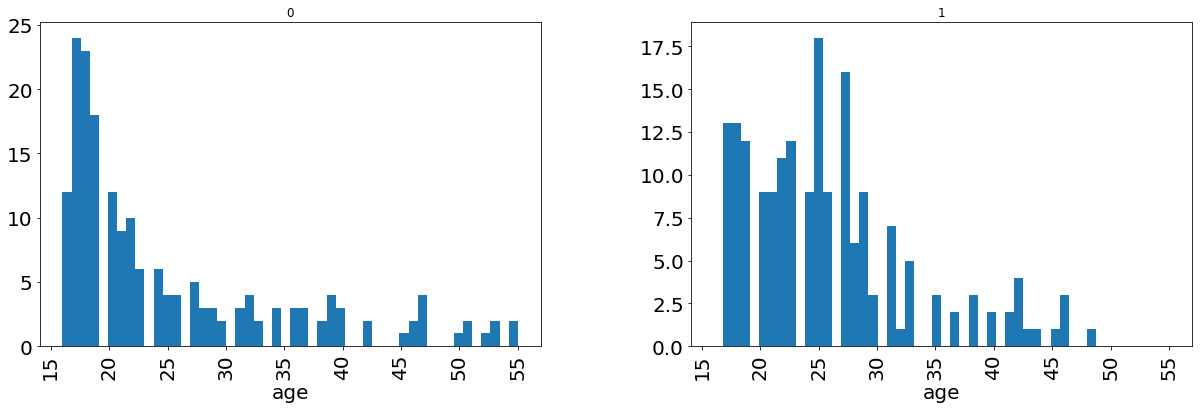

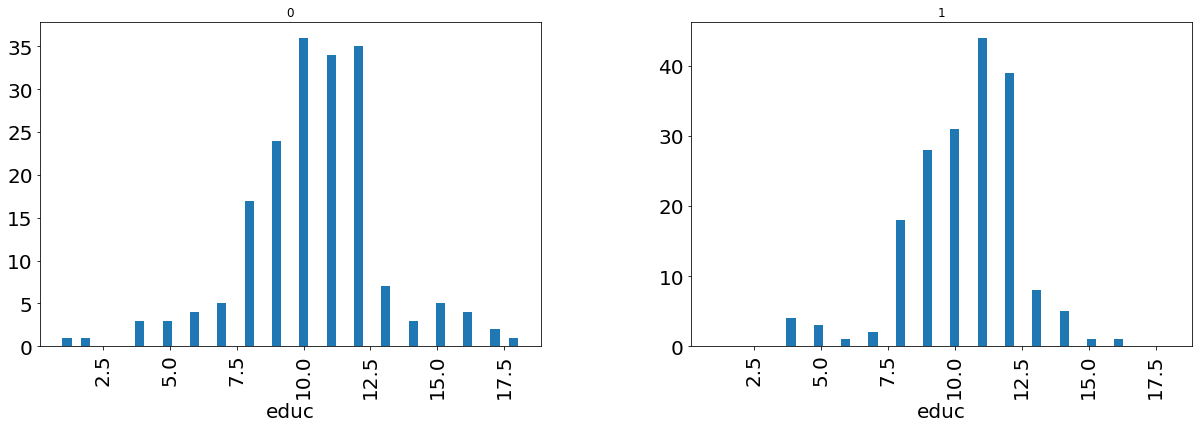

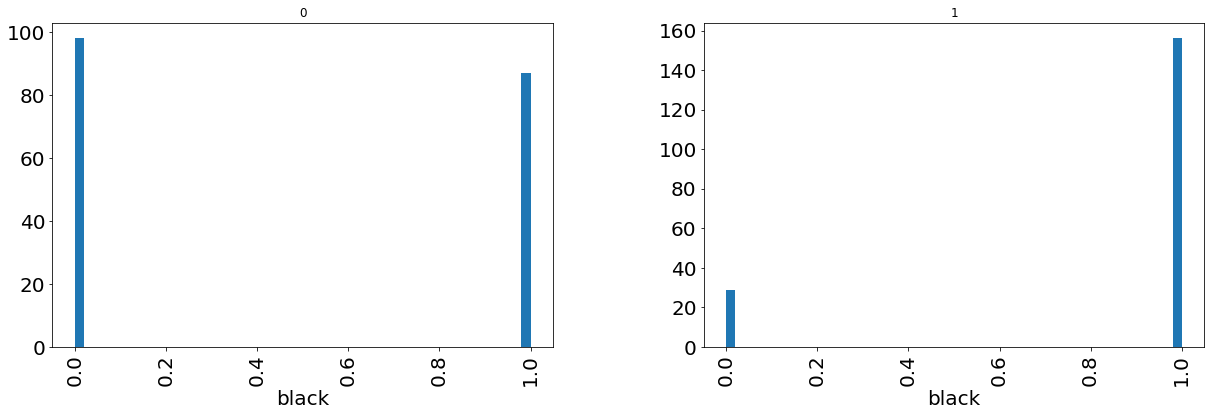

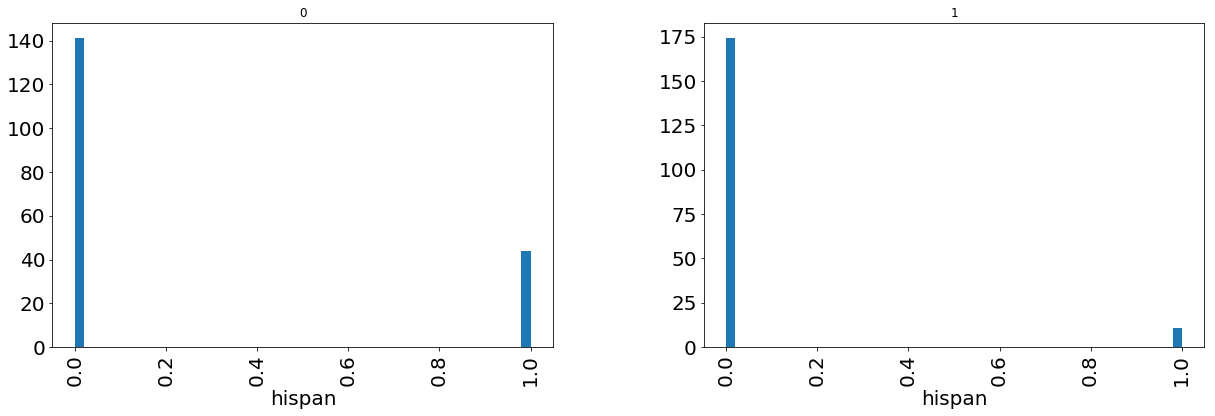

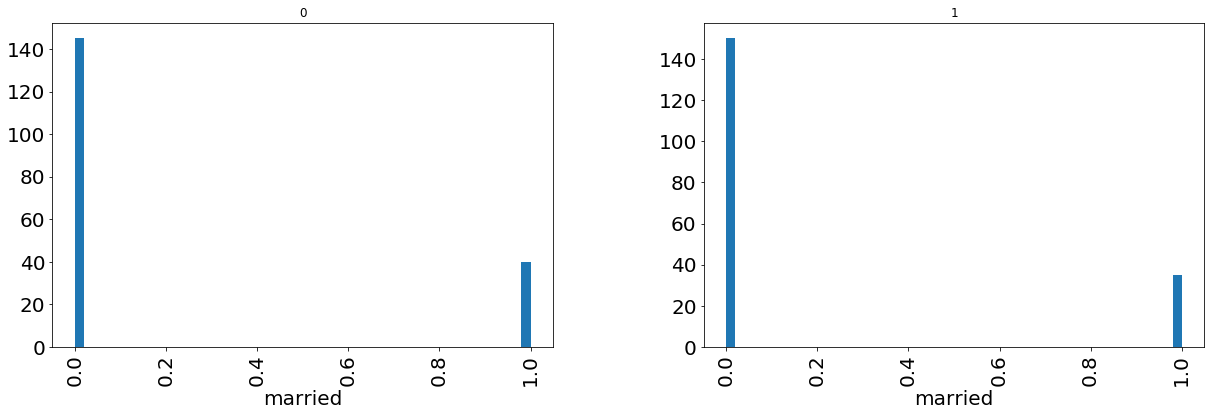

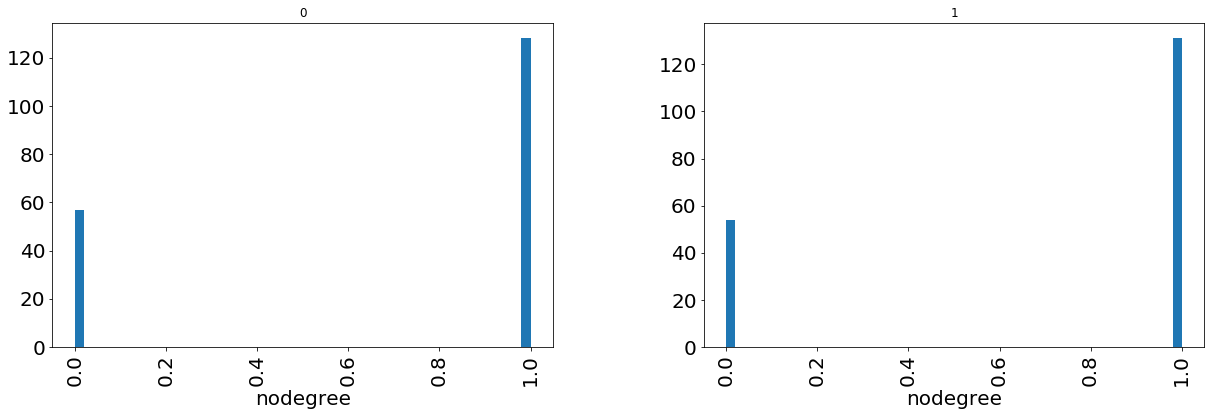

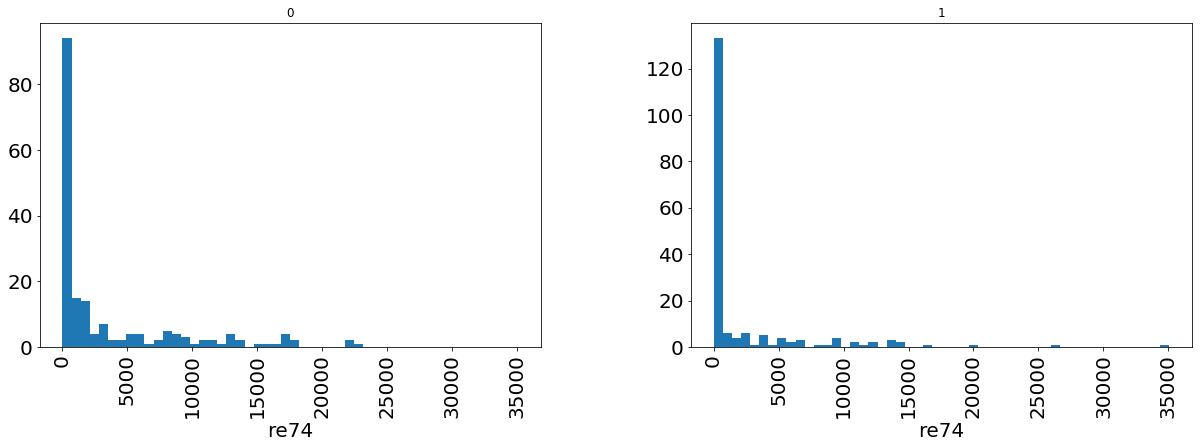

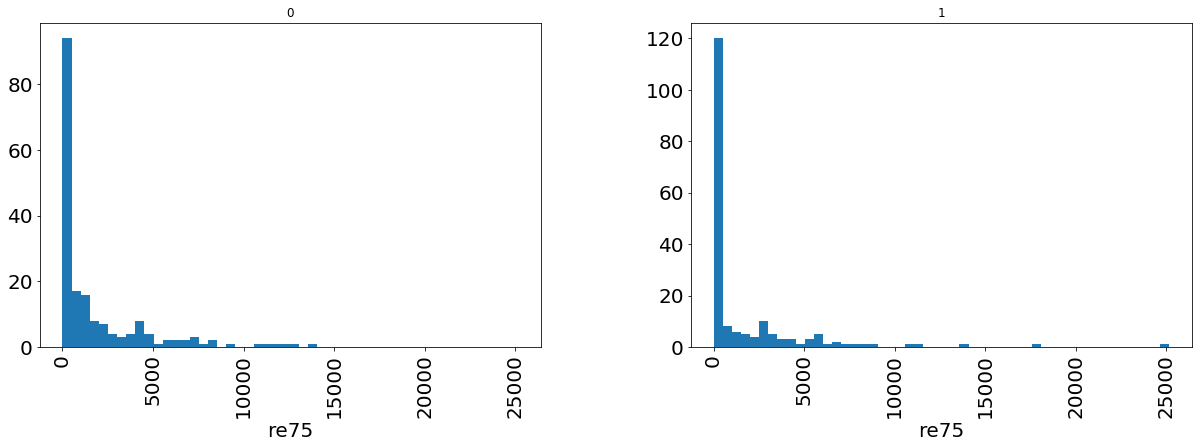

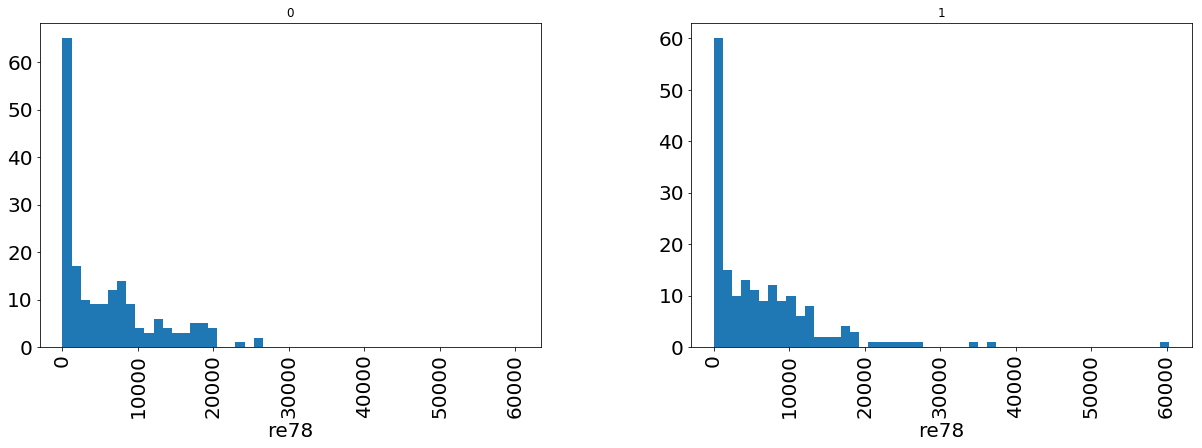

In [20]:
do_variable_histograms(matched_df_1)

As you can see, now the married, educ and nodegree variables are much more balanced, but the extreme imbalance of the black variable still remains, and also the hispan variable has become rather unbalanced (although still not as much as the black variable). So, the two groups are still not sufficiently balanced and the conclusions we draw will probably be considerably affected by the imbalance in the black variable. Therefore, we should try to make sure that the matchings we create are also matched on this variable: a pair of a treatment case and a control case should only be a match if they have equal values for the black variable.

## Parts 5 and 6: Also matching on the problematic variables

Now we will also match on the black variable, by first imposing a huge cost on the inclusion of an edge with unequal values of this variable on the two vertices, and then by explicitly filtering out the matched pairs that have different black values.

In [21]:
treatment_black = df_full.black.values[Y == 1]
control_black = df_full.black.values[Y == 0]

g = nx.Graph()
g.add_nodes_from(treatment_ids, bipartite=1)
g.add_nodes_from(control_ids, bipartite=0)
edge_list = []
for t_index in range(len(treatment_ids)):
    for c_index in range(len(control_ids)):
        edge_list.append((treatment_ids[t_index], control_ids[c_index], -abs(treatment_prop_scores[t_index] - control_prop_scores[c_index]) - 1e10 * abs(treatment_black[t_index] - control_black[c_index])))

g.add_weighted_edges_from(edge_list)
matching_result = nx.max_weight_matching(g, maxcardinality=True)

In [22]:
len(matching_result)

370

Here we make our matching strict and only keep the matched pairs with equal values for the black variable in the pair.

In [23]:
count = 0
strictly_matched = {}
for k in matching_result:
    b1 = df_full[df_full.id == k].black.values[0]
    b0 = df_full[df_full.id == matching_result[k]].black.values[0]
    if (b1 == b0):
        strictly_matched[k] = matching_result[k]
        

In [24]:
matched_df_2 = df_full[df_full.id.isin(strictly_matched)]

Here you can see the descriptive statistics for the control and treatment cases in the matched pairs. As you can see, there is a significant increase in the mean income and also in the quartiles.

Descriptive statistics for the matched cases in the treatment group

count      116.000000
mean      7134.356927
std       8749.918685
min          0.000000
25%        665.300000
50%       4895.704000
75%      10160.440000
max      60307.930000
Name: re78, dtype: float64


Descriptive statistics for the matched cases in the control group
count      116.000000
mean      5214.986226
std       6254.521988
min          0.000000
25%          0.000000
50%       2394.656000
75%       8340.658000
max      25564.670000
Name: re78, dtype: float64


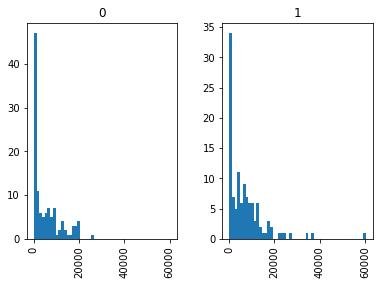

In [25]:
matched_df_2.hist(column='re78', by = 'treat', range=[0, matched_df_2.re78.max()], bins = 50)

describe_treatment_control(matched_df_2, 're78')

And below are the histograms of the variables in this new dataset. Finally, the black variable is balanced across the two. Now we can, with a relatively high degree of certainty, claim that this job program has significantly raised the income of those who have participated in it, compared to others having similar (observed) conditions who have not taken part in the program.

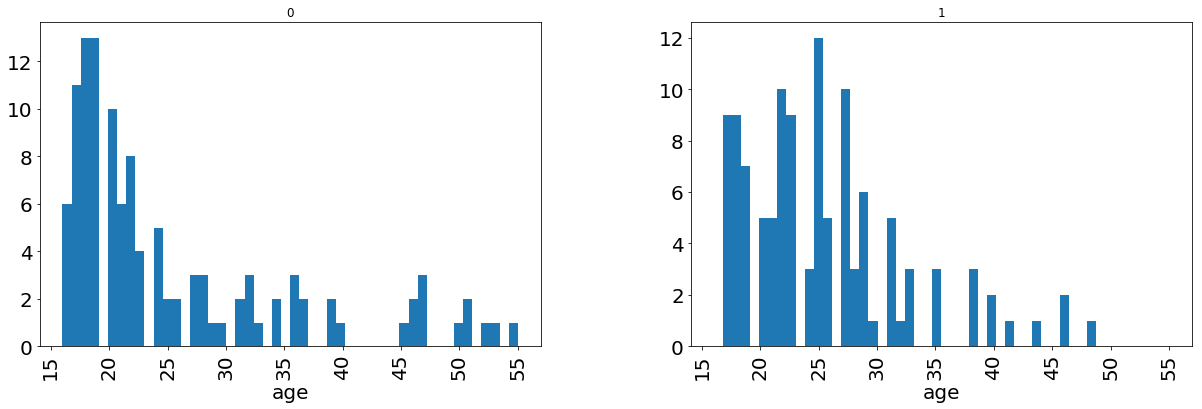

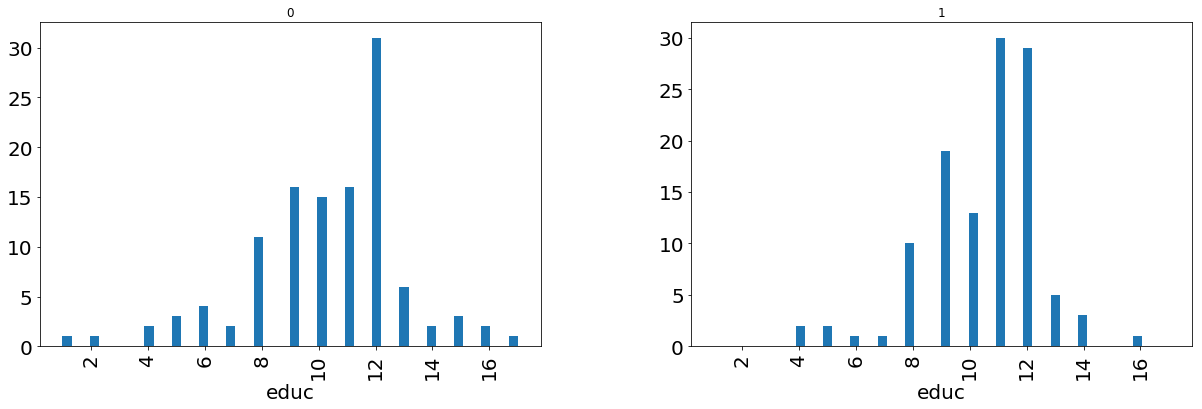

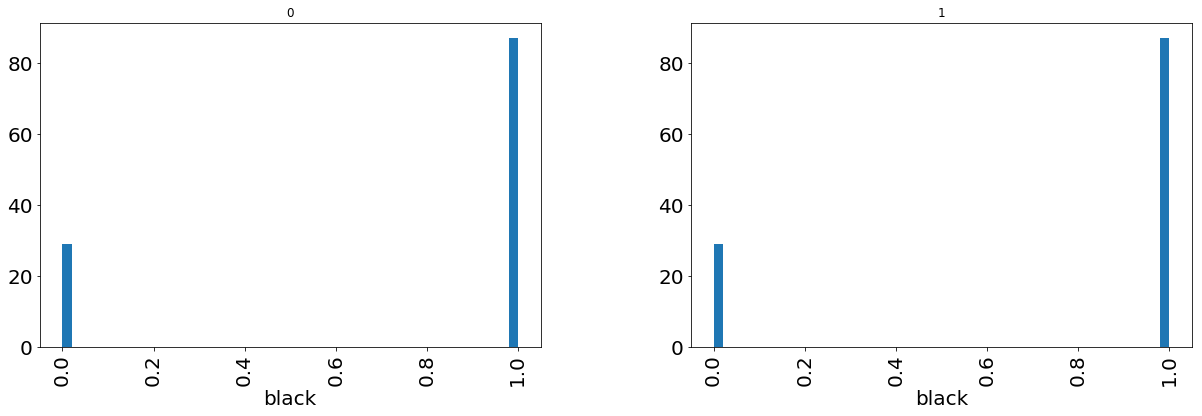

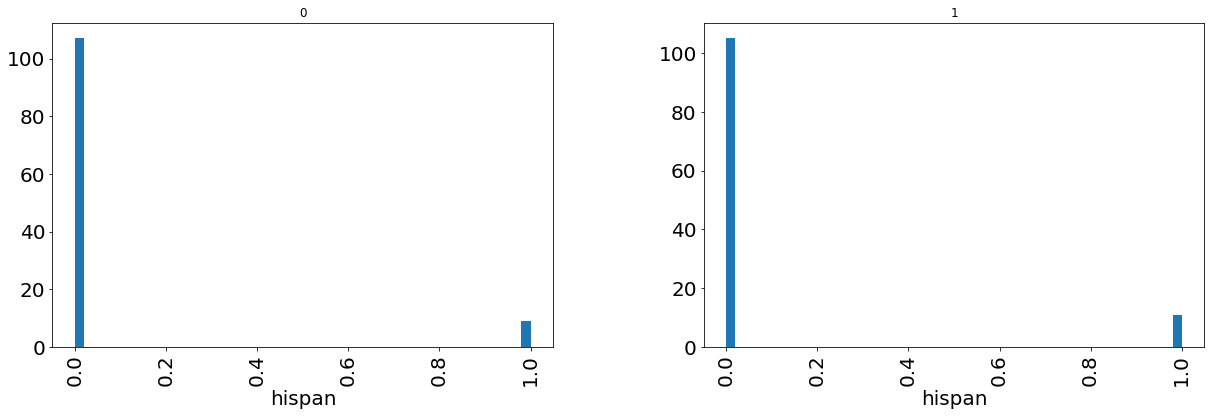

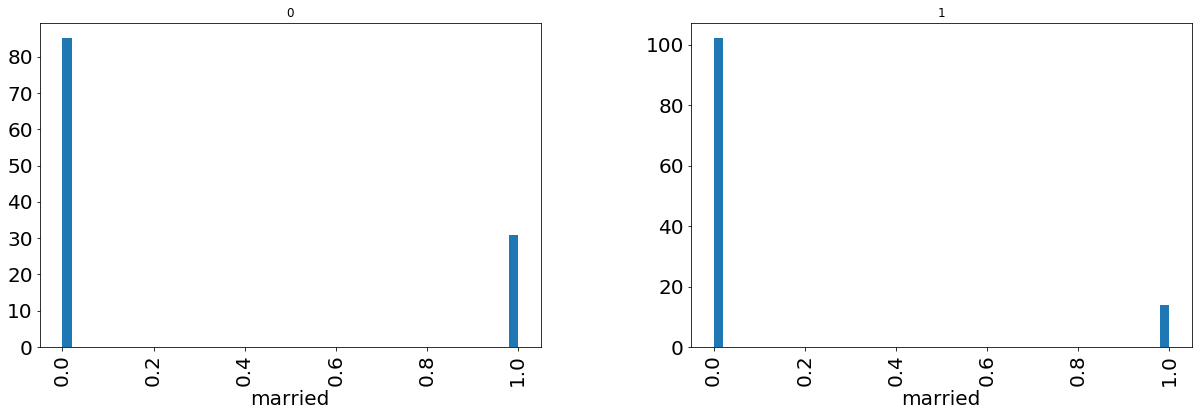

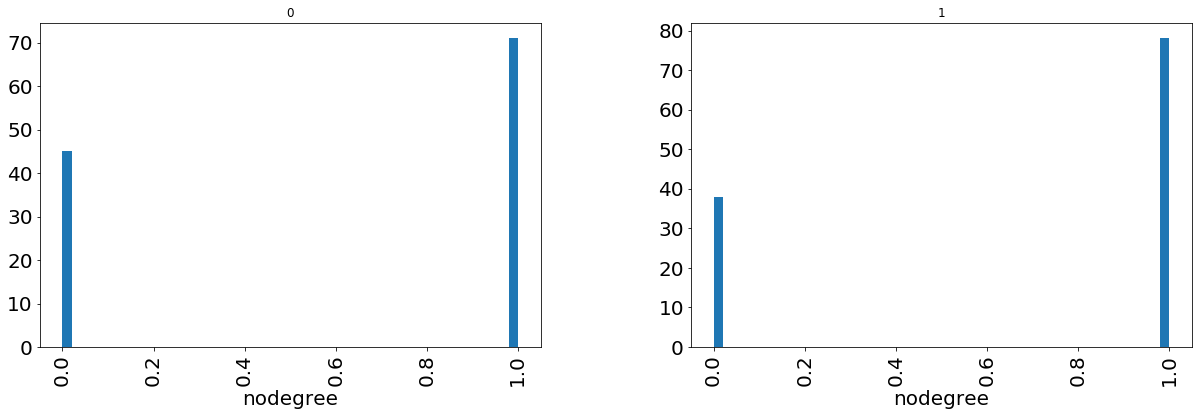

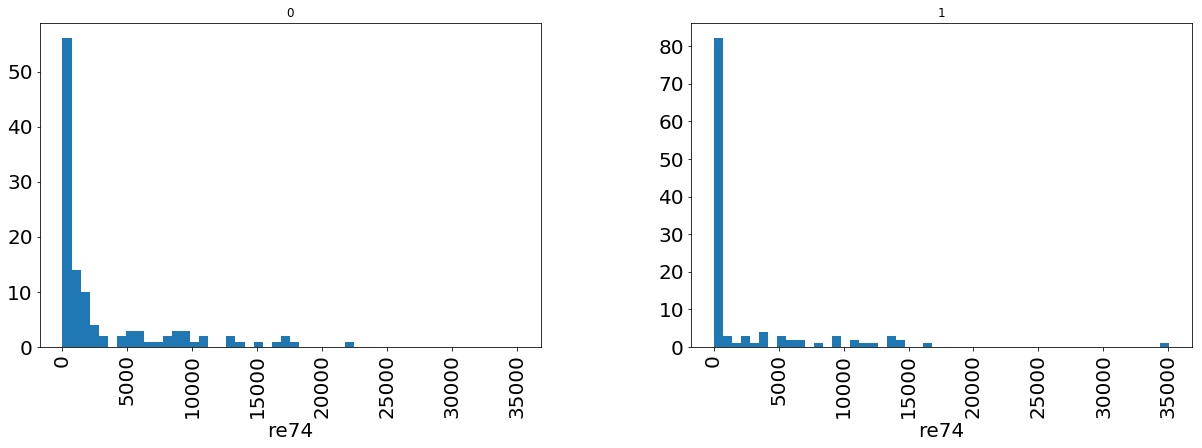

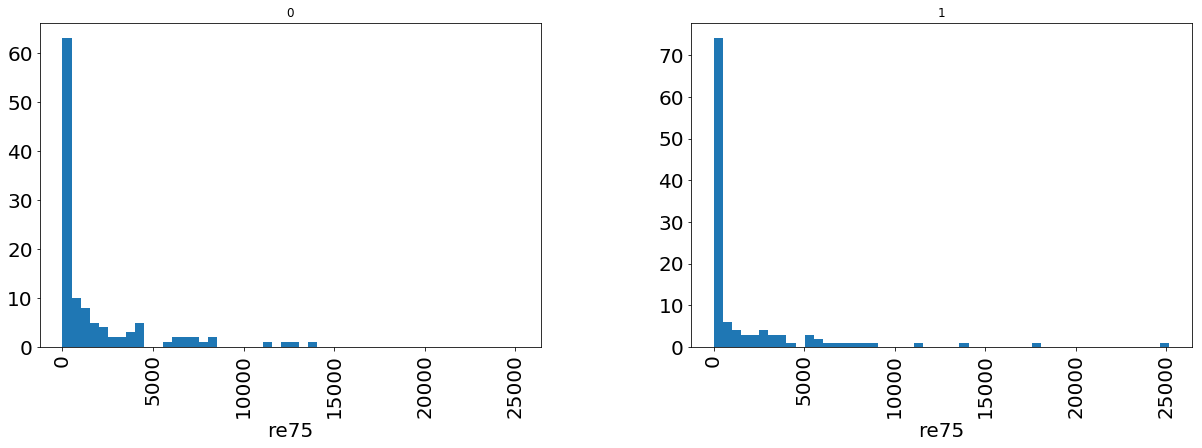

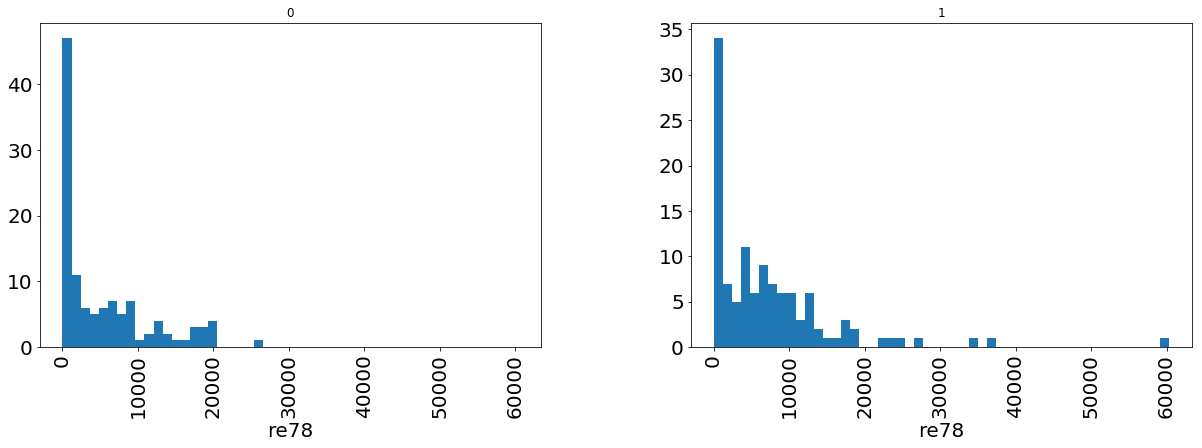

In [26]:
do_variable_histograms(matched_df_2)

# Question 2: Applied ML
first, we load the 20 Newsgroup data set from sklearn library. This data set contains about 18000 newsgroup post on 20 topics. There is already a tarin and test split in the original data set which can be selected by picking the `subset` attribute as train or test. However, here we choose to load the whole data set and then we split it manually for trani and test data.

It is important to remove the `headers`, `footers`, `quotes` from the data set in order to have more realistic results. The reason is that it is easy for a classifier to overfit on particular things that appear in the 20 Newsgroups data, such as newsgroup headers. Therefore, without removing these parts our classifier would not be generalized enough.

In [6]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))

here we see a list of 20 topics contained in the 20 Newsgroup dataset.

In [7]:
print(list(newsgroups.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Next, we ecompute the Tf-Idf features for every article using <a href=http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.get_feature_names>TfidfVectorizer</a>. The output of this function is a matrix with number of rows equal to the number of articles and the number of columns equal to the whole number of terms found in the data set. We also choose to remove the stop words when compuring the Tf-Idf matrix. Stop words are words which are useless for the classification task, i.e. words which can appear in any document regardless of its topic for example: the, for, from, at, etc.

Below we can see that TfidfVectorizer has found 134101 different terms in the whole corpus.

In [8]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
vectors.shape

(18846, 134101)

In [9]:
classes = newsgroups.target
classes.shape

(18846,)

Originally, the output of the `fetch_20newsgroups` is a dictionary with 6 keys. We mostly work with the data which contains the textual content of each post and also target_names which contains the class names.

In [10]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

As expected, the Tf-Idf matrix is a sparse matrix since each post contains only a subset of all terms. Below you can see that we have around 65 zeros for each post on average.

In [11]:
print('total number of zeros:', vectors.nnz)
print('{} average zero per data sample'.format(vectors.nnz / float(vectors.shape[0])))

total number of zeros: 1229435
65.23585906823729 average zero per data sample


We, split our data as 10% test data and 90% training data. First of all we shuffle the indices and then we split the data in order to avoid having any biases because of the time of the documents, their topic, etc.

In [12]:
ratio = 0.1
indices = np.random.permutation(vectors.shape[0])
split1 = int(np.floor(ratio*vectors.shape[0]))
test_vectors = vectors[indices[:split1]]
train_vectors = vectors[indices[split1:]]

In [13]:
test_classes = classes[indices[:split1]]
train_classes = classes[indices[split1:]]

We make a list of all terms contained in the corpus. We can see that even after removing stop words still the first 5 terms (sorted alphabetically) are some meaningless numbers.

In [55]:
feature_names = vectorizer.get_feature_names()
feature_names[:5]

['00', '000', '0000', '00000', '000000']

In [16]:
from sklearn.ensemble import RandomForestClassifier

Now we train a simple random forest classifier with the default parameters on the training data and compute its accuracy on test data.

In [17]:
RFclassifier = RandomForestClassifier()
RFclassifier.fit(train_vectors,train_classes)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
test_res = RFclassifier.predict(test_vectors)

We can see that the accuracy on test data is fairly low.

In [19]:
accuracy = np.mean([test_res[i]==test_classes[i] for i in range(len(test_classes))])
print('accuracy = {}%'.format(accuracy))

accuracy = 0.5567940552016986%


Now we try to fine tune the parameters `n_estimsators` and `max_depth` of random forest. The first parameter is the number of trees in the random forest and the second one is that he maximum depth of each tree in random forest. As high values of max_depth parameter leads to significant increase in the execution time of training, we first made a grid search with coarse intervals of max_depth (we removed the results of this part unfortunately) and then we reduced the range of max_depth parameter but with finer intervals.

In [113]:
from sklearn.model_selection import GridSearchCV, cross_val_score
n_estimator = [i for i in range(100,500,100)]
max_depth = [i for i in range(70,100,10)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},n_jobs=-1)
clf.fit(train_vectors,train_classes)

Next we make a pandas data frame from the results of grid search cross-validation. We sort the row by the rank of test score (the mean test score on the fold left out for validation). We can see that we get the best result for a maximum depth of 90 and 400 number of trees (both maximum values in the chosen intervals). This leads us to increase the number of trees even more to get better accuracy.

In [80]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)

In [82]:
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,193.704068,1.861396,0.665959,0.930019,90,400,"{'max_depth': 90, 'n_estimators': 400}",1,0.670081,0.929204,0.667787,0.928552,0.659996,0.932302,8.582209,0.063540,0.004315,0.001636
10,164.356243,1.463070,0.664367,0.928987,90,300,"{'max_depth': 90, 'n_estimators': 300}",2,0.666196,0.927522,0.667433,0.926607,0.659465,0.932833,3.241109,0.011763,0.003500,0.002745
7,192.822175,1.914934,0.663896,0.923003,80,400,"{'max_depth': 80, 'n_estimators': 400}",3,0.661957,0.921858,0.667079,0.920594,0.662653,0.926558,4.649892,0.012043,0.002269,0.002566
6,144.726100,1.384768,0.663188,0.921588,80,300,"{'max_depth': 80, 'n_estimators': 300}",4,0.667079,0.920000,0.666372,0.920064,0.656101,0.924702,4.070652,0.030675,0.005015,0.002202
3,185.075461,1.976391,0.661950,0.912569,70,400,"{'max_depth': 70, 'n_estimators': 400}",5,0.664430,0.911947,0.661596,0.909895,0.659819,0.915864,1.029161,0.081186,0.001899,0.002476


However, having a large number of trees each have relatively a large maximum depth would cause huge execution times. Therefore, we decided to keep the maximum depth small and rather grow the number of trees.

In [114]:
from sklearn.model_selection import GridSearchCV, cross_val_score
n_estimator = [i for i in range(900,1500,100)]
max_depth = [i for i in range(15,25,5)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},n_jobs=-1,cv=10)
clf.fit(train_vectors,train_classes)

In [24]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)

The data frame below shows the results for 10 fold cross validation. As we can see the best score is significatly lower than previous best result. So it seems that max_depth parameter have more significat effect on the accuracy.

In [29]:
df.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,206.403024,2.846908,0.627815,0.735801,20,1400,"{'max_depth': 20, 'n_estimators': 1400}",1,0.626831,0.736021,...,0.624113,0.736804,0.626257,0.737738,0.629739,0.734909,5.851897,0.656986,0.005390,0.001231
6,258.454027,5.016123,0.627167,0.734825,20,900,"{'max_depth': 20, 'n_estimators': 900}",2,0.629760,0.733727,...,0.617021,0.735036,0.619752,0.732434,0.636848,0.737070,124.671179,4.633514,0.008866,0.001725
8,172.650512,2.227015,0.626990,0.736090,20,1100,"{'max_depth': 20, 'n_estimators': 1100}",3,0.632689,0.734448,...,0.617612,0.736477,0.623300,0.735774,0.638033,0.735564,6.941250,0.413777,0.006558,0.001622
9,175.958252,2.087759,0.626695,0.735500,20,1200,"{'max_depth': 20, 'n_estimators': 1200}",4,0.627417,0.735169,...,0.619976,0.737590,0.625074,0.733547,0.632109,0.733665,2.792028,0.224548,0.007453,0.001770
10,191.684709,2.696582,0.626223,0.735048,20,1300,"{'max_depth': 20, 'n_estimators': 1300}",5,0.637376,0.734907,...,0.615248,0.738441,0.627439,0.735512,0.633886,0.735367,4.519714,0.630316,0.009602,0.001854
7,271.482889,2.253534,0.623747,0.734131,20,1000,"{'max_depth': 20, 'n_estimators': 1000}",6,0.623902,0.734513,...,0.616430,0.735560,0.620343,0.736232,0.638033,0.734058,184.672345,0.618140,0.007267,0.001235
5,198.187554,3.269956,0.617321,0.696564,15,1400,"{'max_depth': 15, 'n_estimators': 1400}",7,0.623316,0.695969,...,0.609338,0.695940,0.613247,0.697007,0.632109,0.695430,15.059122,0.926720,0.007486,0.001354
4,143.185758,3.339114,0.615552,0.695548,15,1300,"{'max_depth': 15, 'n_estimators': 1300}",8,0.622730,0.697607,...,0.605201,0.697708,0.615021,0.697335,0.626185,0.694383,8.400814,1.927593,0.009330,0.002290
2,126.310065,2.051716,0.614432,0.695672,15,1100,"{'max_depth': 15, 'n_estimators': 1100}",9,0.619801,0.693281,...,0.605201,0.698690,0.612064,0.697073,0.625000,0.696085,7.743560,0.841904,0.007274,0.001895
3,128.958863,1.648862,0.613489,0.695902,15,1200,"{'max_depth': 15, 'n_estimators': 1200}",10,0.619215,0.692822,...,0.606383,0.692993,0.605559,0.696418,0.618483,0.692484,2.607042,0.151737,0.008274,0.002231


FInally, for getting our bst results we do a cross validation with our best parameters max_depth=90 and n_estimators=1500. 

In [30]:
n_estimator = [i for i in range(1500,1600,100)]
max_depth = [i for i in range(90,100,10)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},verbose=2,n_jobs=-1,cv=10)
clf.fit(train_vectors,train_classes)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=90, n_estimators=1500 .................................
[CV] max_depth=90, n_estimators=1500 .................................
[CV] max_depth=90, n_estimators=1500 .................................
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.2min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.4min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.6min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.8min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=33.4min
[CV] max_depth=9

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 75.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1500], 'max_depth': [90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [31]:
df1 = pd.DataFrame(clf.cv_results_)
df1.sort_values('rank_test_score',inplace=True)

We can see that our best accuracy on test data is 67.8%. Compared to the first grid search we have almost tripled our n_estimators while keeping max_depth the same, however the increase in the test score is not very significant given that the execution time was much higher for the latter parameter. This again shows that max_depth is more effective.

Apart from this, to get better scores much more preprocessing should be done on the textual data. For example as we showed above there were some all zeros terms in data which seemed meaningless for classification and probably should be removed. Also stemming and lemmatization will also help to both reduce the number of terms in Tf-Idf and increase the accuracy.

In [56]:
df1.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1515.116965,9.105797,0.678694,0.921884,90,1500,"{'max_depth': 90, 'n_estimators': 1500}",1,0.681898,0.919961,...,0.675532,0.921676,0.678888,0.920437,0.685427,0.922417,419.340684,3.010958,0.005734,0.001103


In [37]:
best_classifier = RandomForestClassifier(n_estimators=1500,max_depth=90,n_jobs=-1)
best_classifier.fit(train_vectors,train_classes)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

At the end we make a prediction on test data using our best classifier. We see that the accuracy is 67.5% as expected.

In [41]:
test_res = best_classifier.predict(test_vectors)

In [42]:
accuracy = np.mean([test_res[i]==test_classes[i] for i in range(len(test_classes))])
print('accuracy = {}%'.format(accuracy))

accuracy = 0.6756900212314225%


In [44]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_classes, test_res)

Finally we visualize the confusion matrix of our classifier (<a href=http://scikit-learn.org/0.15/auto_examples/model_selection/plot_confusion_matrix.html>Confusion matrix</a>). It shows that how many time a class was mislabelled by other classes.

Confusion matrix, without normalization


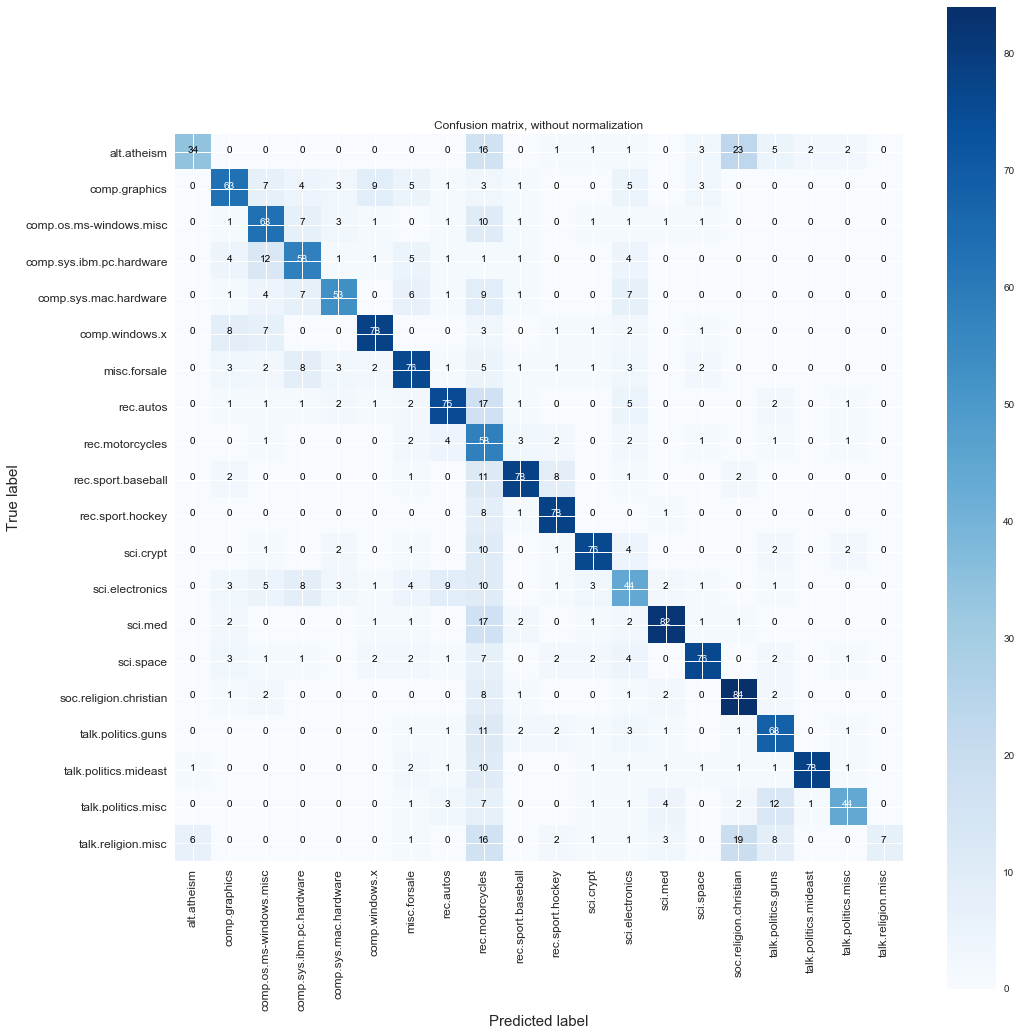

In [54]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')


In the above matrix we can see that in most of the cases, similar classes are mislabelled. For example _atheism_ is mislabelled 6 times with _religion_. We list below some other examples:
- _ms-windows_ has been mislabelled 12 times with _hardware_.
- _windows.x_ has benn mislabelled 9 times with _graphics_.
- _autos_ has been mislabelled 9 times with _electronics_ which makes sense somehow. maybe there were some post about electronic system of cars or electric cars.
- _christian_ has been mislabelled 23 times with _atheism_ and 19 times with _religion_.
- _guns_ has been mislabelled 12 times with _politics_.

The only wierd thing is about _motorcycles_ category which has been mislabelled with Quiet a lot of unrelated subjects. For example 16 times with _religion_ and 17 times with _atheism_ and 17 times with autos. It seems that smples in this class are contributing a lot to misclassifications.

Below we can see the top 10 most important terms in the corpus. We can easily find relationship between these words and categories. For example windows is probably related to _ms_windows_ and _windows.x_ class. 

In [43]:
importance = best_classifier.feature_importances_
sorted_indicies = np.argsort(importance)
sorted_indicies = sorted_indicies[::-1]
[feature_names[i] for i in sorted_indicies[:10]]

['windows',
 'bike',
 'car',
 'sale',
 'god',
 'space',
 'game',
 'israel',
 'clipper',
 'hockey']